In [1]:
# VPG, A3C, A2C, SAC, TSAC

In [2]:
!nvidia-smi

Sat Dec  1 01:09:27 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 415.18       Driver Version: 415.18       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 00000000:0B:00.0 Off |                  N/A |
| 23%   30C    P8    10W / 250W |      2MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN X (Pascal)    Off  | 00000000:41:00.0  On |                  N/A |
| 36%   61C    P0    60W / 250W |   1290MiB / 12188MiB |      4%      Default |
+-------------------------------+----------------------+----------------------+
        

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from IPython.display import display
from collections import namedtuple, deque
import matplotlib.pyplot as plt
from itertools import cycle, count
from textwrap import wrap

import subprocess
import os.path
import tempfile
import random
import base64
import pprint
import time
import json
import sys
import gym
import io

from gym import wrappers
from subprocess import check_output
from IPython.display import HTML

plt.style.use('fivethirtyeight')
np.set_printoptions(suppress=True)

%matplotlib inline

In [4]:
torch.cuda.is_available()

True

In [5]:
def make_monitored_env(env_name, monitor_mode, seed):
    mdir = tempfile.mkdtemp()
    env = gym.make(env_name)
    env = wrappers.Monitor(env, mdir, force=True, mode=monitor_mode)
    env.seed(seed)
    return env

In [6]:
def plot_results(results, log_scale=False):
    plt.figure(figsize=(15, 10))
    lines = ["-","--",":","-."]
    linecycler = cycle(lines)
    for experiment, experiment_name, env in results:
        label = '\n'.join(wrap(experiment_name.replace('_', ', '), 50))
        plt.plot(experiment, next(linecycler), label=label)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if log_scale: plt.xscale('log')
    plt.ylabel('Rewards')
    plt.xlabel('Episode')
    plt.show()

In [7]:
def get_videos_html(env_videos, title, max_n_videos=3):
    videos = np.array(env_videos)
    n_videos = min(max_n_videos, len(videos))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int)
    videos = videos[idxs,:]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        video = io.open(video_path, 'r+b').read()
        encoded = base64.b64encode(video)

        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <video width="960" height="540" controls>
            <source src="data:video/mp4;base64,{1}" type="video/mp4" />
        </video>"""
        strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
    return strm

In [8]:
def get_gif_html(env_videos, title, max_n_videos=3):
    videos = np.array(env_videos)
    n_videos = min(max_n_videos, len(videos))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int)
    videos = videos[idxs,:]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        basename = os.path.splitext(video_path)[0]
        gif_path = basename + '.gif'
        if not os.path.exists(gif_path):
            ps = subprocess.Popen(
                ('ffmpeg', 
                 '-i', video_path, 
                 '-r', '10', 
                 '-f', 'image2pipe', 
                 '-vcodec', 'ppm', 
                 '-'), 
                stdout=subprocess.PIPE)
            output = subprocess.check_output(
                ('convert', 
                 '-delay', '5', 
                 '-loop', '0', 
                 '-', gif_path), 
                stdin=ps.stdout)
            ps.wait()

        gif = io.open(gif_path, 'r+b').read()
        encoded = base64.b64encode(gif)
            
        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <img src="data:image/gif;base64,{1}" />"""
        strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
    return strm

In [9]:
class FCQV(nn.Module):
    def __init__(self, 
                 input_dim, 
                 output_dim, 
                 hidden_dims=(32,32), 
                 init_weight=0.003,
                 activation_fc=F.relu):
        super(FCQV, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim + output_dim, 
                                     hidden_dims[0])

        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(
                hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)

        self.output_layer = nn.Linear(
            hidden_dims[-1], 1)
        
        self.output_layer.weight.data.uniform_(
            -init_weight, init_weight)
        self.output_layer.bias.data.uniform_(
            -init_weight, init_weight)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)

    def forward(self, state, action):
        x, u = state, action
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        if not isinstance(u, torch.Tensor):
            u = torch.tensor(u, 
                             device=self.device, 
                             dtype=torch.float32)
            u = u.unsqueeze(0)

        x = torch.cat((x, u), dim=1)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        return x

    def numpy_float_to_device(self, variable):
        variable = torch.from_numpy(variable).float().to(self.device)
        return variable
    
    def load_experiences(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).float().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals

In [10]:
class FCP(nn.Module):
    def __init__(self, 
                 input_dim, 
                 output_dim,
                 max_action,
                 hidden_dims=(32,32), 
                 init_weight=0.003,
                 activation_fc=F.relu):
        super(FCP, self).__init__()
        self.activation_fc = activation_fc
        self.max_action = max_action

        self.input_layer = nn.Linear(input_dim, 
                                     hidden_dims[0])
        
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(
                hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
                
        self.output_layer = nn.Linear(
            hidden_dims[-1], output_dim)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)
        
        self.output_layer.weight.data.uniform_(
            -init_weight, init_weight)
        self.output_layer.bias.data.uniform_(
            -init_weight, init_weight)


    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        x = self.max_action * torch.tanh(x)
        return x
    
    def select_action(self, state):
        action = self.forward(state)
        action = action.detach().cpu().numpy()[0]
        return action

    def numpy_float_to_device(self, variable):
        variable = torch.from_numpy(variable).float().to(self.device)
        return variable
    
    def load_experiences(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).float().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals

In [11]:
class ReplayBuffer():
    def __init__(self, 
                 max_samples=100000,
                 batch_size=32):
        self.memory = deque(maxlen=max_samples)
        self.batch_size = batch_size

    def store(self, sample):
        self.memory.append(sample)

    def sample(self, batch_size=None):
        if batch_size == None:
            batch_size = self.batch_size  
        idxs = np.random.choice(
            len(self.memory), 
            batch_size,
            replace=False)
        samples = np.array(
            [self.memory[idx] for idx in idxs])
        batches = [
            np.vstack(sars) for sars in samples.T]
        return batches
    
    def is_prioritized(self):
        return False

    def __len__(self):
        return len(self.memory)

In [12]:
class TD3Noise():
    def __init__(self, nA, noise=0.1):
        self.nA = nA
        self.noise = noise

    def __call__(self):
        return np.random.normal(0, self.noise, size=self.nA)
    
    def reset(self):
        pass

In [1]:
class OUDecayingNoise():
    def __init__(self, mu, sigma, theta, max_steps, dt=0.01):
        self.t = 0
        self.mu = mu
        self.sigma = sigma
        self.theta = theta
        self.dt = dt
        self.max_steps = max_steps
        self.reset()

    def __call__(self):
        a = self.theta * (self.mu - self.x) * self.dt
        b = self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        x = self.x + a + b
        decay = max(0, 1 - self.t / self.max_steps)
        
        self.x = x
        self.t += 1

        return x * decay

    def reset(self):
        self.x = np.zeros_like(self.mu)

# VPG

In [15]:
environment_settings = {
    'training_env_name': 'Pendulum-v0',
    'testing_env_name': 'Pendulum-v0',
    'gamma': 0.99,
    'max_episodes': 1000,
    'max_mean_reward': -150,
    'print_every_episodes': 25,
    'save_every_episodes': 1500,
    'n_evaluation_episodes': 10,
}

buffer = lambda: ReplayBuffer(max_samples=1000000, batch_size=256)
qvalue_model = lambda nS, nA: FCQV(nS, nA, hidden_dims=(512,256))
qvalue_optimizer = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
qvalue_optimizer_lr = 0.01

policy_model = lambda nS, nA, max_action: FCP(nS, nA, max_action, hidden_dims=(512,256))
policy_optimizer = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
policy_optimizer_lr = 0.0001

seed = 12345
update_target_every_timesteps = 1
train_every_timesteps = 1
tau = 0.005
max_gradient = float('inf')
n_warmup_batch = 5

training_env_name, testing_env_name, gamma, max_episodes, \
  max_mean_reward, print_every_episodes, save_every_episodes, \
  n_evaluation_episodes = environment_settings.values()

strategy = lambda nA: OUDecayingNoise(
    mu=np.zeros(nA), sigma=0.2 * np.ones(nA), 
    theta=0.15, max_steps=max_episodes*0.8)
strategy = lambda nA: TD3Noise(nA)

torch.manual_seed(seed)
np.random.seed(seed)

agent = VPGAgent(buffer, qvalue_model, qvalue_optimizer, qvalue_optimizer_lr,
                 policy_model, policy_optimizer, policy_optimizer_lr, strategy,
                 update_target_every_timesteps, train_every_timesteps, 
                 tau, max_gradient, n_warmup_batch, 
                 print_every_episodes, save_every_episodes=5000,
                 experiment_name='default')

training_env = make_monitored_env(
    training_env_name, 'training', seed)
rewards = agent.train(
    training_env, gamma=gamma, 
    max_episodes=max_episodes, max_mean_reward=max_mean_reward)

/opt/conda/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


ep 025, tmstps 05000, explr rat 1.00, buf sze 05000, 25/100 ep av rew -1256.85/-1256.85, 100 ep av sec 1.48
ep 050, tmstps 10000, explr rat 1.00, buf sze 10000, 25/100 ep av rew -1156.03/-1206.44, 100 ep av sec 1.59
ep 075, tmstps 15000, explr rat 1.00, buf sze 15000, 25/100 ep av rew -412.46/-941.78, 100 ep av sec 1.62
ep 100, tmstps 20000, explr rat 1.00, buf sze 20000, 25/100 ep av rew -216.90/-760.56, 100 ep av sec 1.64
ep 125, tmstps 25000, explr rat 1.00, buf sze 25000, 25/100 ep av rew -159.82/-486.30, 100 ep av sec 1.70
ep 150, tmstps 30000, explr rat 1.00, buf sze 30000, 25/100 ep av rew -140.45/-232.41, 100 ep av sec 1.74
ep 175, tmstps 35000, explr rat 1.00, buf sze 35000, 25/100 ep av rew -157.87/-168.76, 100 ep av sec 1.76
ep 200, tmstps 40000, explr rat 1.00, buf sze 40000, 25/100 ep av rew -153.86/-153.00, 100 ep av sec 1.79
ep 225, tmstps 45000, explr rat 1.00, buf sze 45000, 25/100 ep av rew -162.24/-153.61, 100 ep av sec 1.82
ep 250, tmstps 50000, explr rat 1.00, buf 

NameError: name 'experiment_name' is not defined


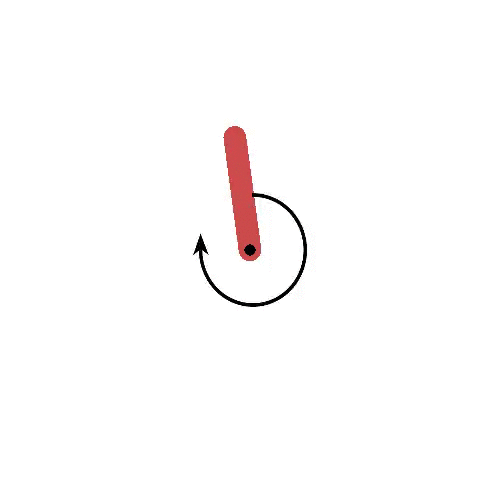
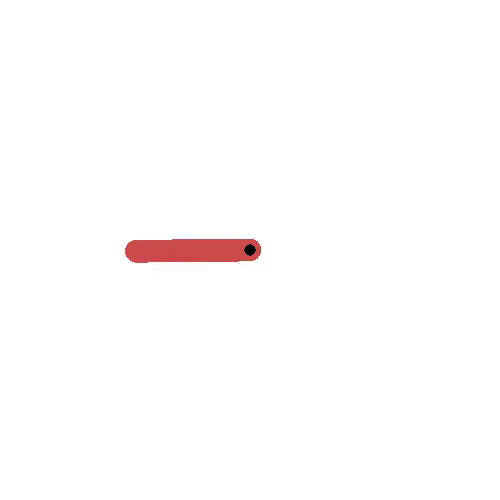
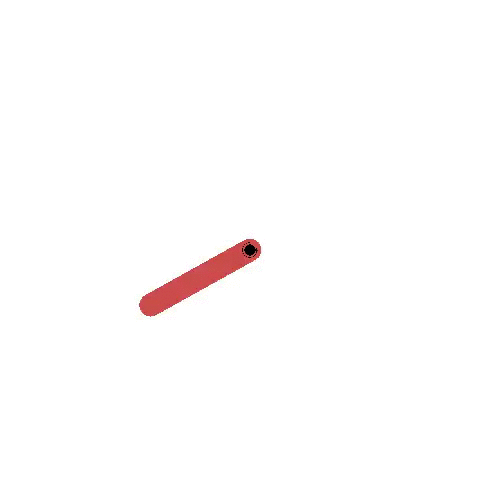

In [16]:
HTML(data=get_gif_html(env_videos=training_env.videos, title='Training evolution', max_n_videos=3))

# A3C

In [19]:
environment_settings = {
    'training_env_name': 'Pendulum-v0',
    'testing_env_name': 'Pendulum-v0',
    'gamma': 0.99,
    'max_episodes': 1000,
    'max_mean_reward': -150,
    'print_every_episodes': 25,
    'save_every_episodes': 1500,
    'n_evaluation_episodes': 10,
}

buffer = lambda: ReplayBuffer(max_samples=1000000, batch_size=256)
qvalue_model = lambda nS, nA: FCTQV(nS, nA, hidden_dims=(512,256))
qvalue_optimizer = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
qvalue_optimizer_lr = 0.01

policy_model = lambda nS, nA, max_action: FCP(nS, nA, max_action, hidden_dims=(512,256))
policy_optimizer = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
policy_optimizer_lr = 0.0001

seed = 12345
update_target_every_timesteps = 2
update_policy_every_timesteps = 2
train_every_timesteps = 1
tau = 0.005
max_gradient = float('inf')
n_warmup_batch = 5

training_env_name, testing_env_name, gamma, max_episodes, \
  max_mean_reward, print_every_episodes, save_every_episodes, \
  n_evaluation_episodes = environment_settings.values()

strategy = lambda nA: OUDecayingNoise(
    mu=np.zeros(nA), sigma=0.2 * np.ones(nA), 
    theta=0.15, max_steps=max_episodes*0.8)
strategy = lambda nA: TD3Noise(nA)

torch.manual_seed(seed)
np.random.seed(seed)

agent = TD3Agent(buffer, qvalue_model, qvalue_optimizer, qvalue_optimizer_lr,
                 policy_model, policy_optimizer, policy_optimizer_lr, strategy,
                 update_target_every_timesteps, update_policy_every_timesteps, 
                 train_every_timesteps, 
                 tau, max_gradient, n_warmup_batch, 
                 print_every_episodes, save_every_episodes=5000,
                 experiment_name='default')

training_env = make_monitored_env(
    training_env_name, 'training', seed)
rewards = agent.train(
    training_env, gamma=gamma, 
    max_episodes=max_episodes, max_mean_reward=max_mean_reward)

/opt/conda/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


ep 025, tmstps 05000, explr rat 1.00, buf sze 05000, 25/100 ep av rew -1334.45/-1334.45, 100 ep av sec 1.44
ep 050, tmstps 10000, explr rat 1.00, buf sze 10000, 25/100 ep av rew -927.79/-1131.12, 100 ep av sec 1.59
ep 075, tmstps 15000, explr rat 1.00, buf sze 15000, 25/100 ep av rew -337.90/-866.71, 100 ep av sec 1.63
ep 100, tmstps 20000, explr rat 1.00, buf sze 20000, 25/100 ep av rew -214.11/-703.56, 100 ep av sec 1.65
ep 125, tmstps 25000, explr rat 1.00, buf sze 25000, 25/100 ep av rew -212.46/-423.06, 100 ep av sec 1.73
ep 150, tmstps 30000, explr rat 1.00, buf sze 30000, 25/100 ep av rew -143.09/-226.89, 100 ep av sec 1.75
ep 175, tmstps 35000, explr rat 1.00, buf sze 35000, 25/100 ep av rew -165.14/-183.70, 100 ep av sec 1.76
ep 200, tmstps 40000, explr rat 1.00, buf sze 40000, 25/100 ep av rew -173.81/-173.63, 100 ep av sec 1.74
ep 225, tmstps 45000, explr rat 1.00, buf sze 45000, 25/100 ep av rew -159.55/-160.40, 100 ep av sec 1.79
ep 250, tmstps 50000, explr rat 1.00, buf s

NameError: name 'experiment_name' is not defined


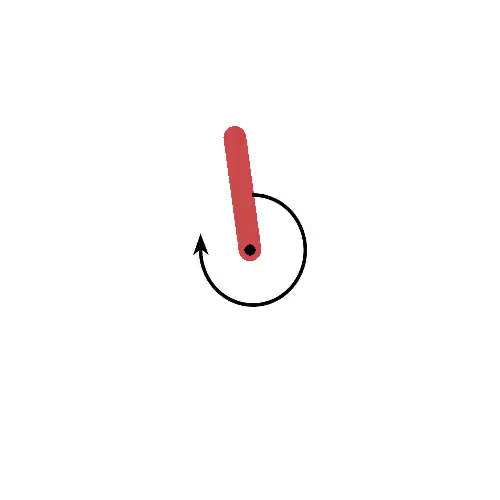
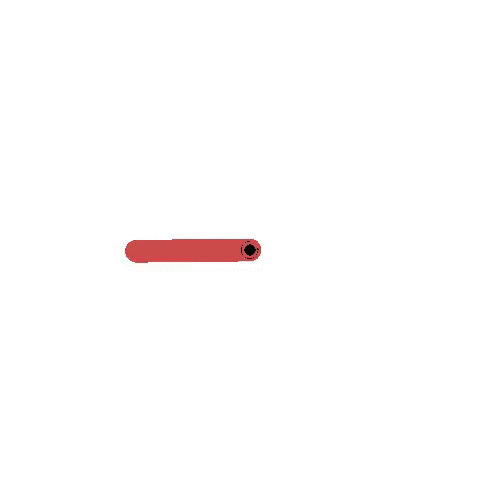
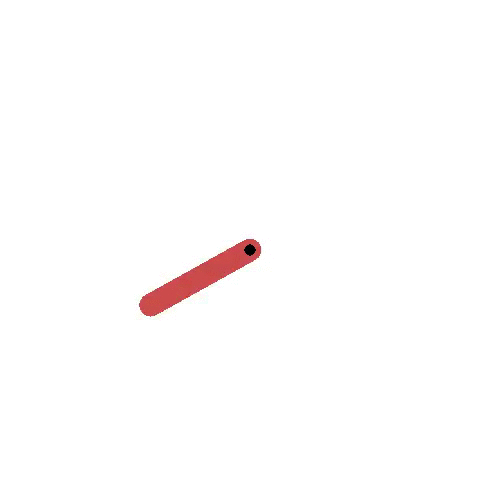

In [20]:
HTML(data=get_gif_html(env_videos=training_env.videos, title='Training evolution', max_n_videos=3))

# A2C

In [ ]:
environment_settings = {
    'training_env_name': 'Pendulum-v0',
    'testing_env_name': 'Pendulum-v0',
    'gamma': 0.99,
    'max_episodes': 1000,
    'max_mean_reward': -150,
    'print_every_episodes': 25,
    'save_every_episodes': 1500,
    'n_evaluation_episodes': 10,
}

buffer = lambda: ReplayBuffer(max_samples=1000000, batch_size=256)
qvalue_model = lambda nS, nA: FCQV(nS, nA, hidden_dims=(512,256))
qvalue_optimizer = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
qvalue_optimizer_lr = 0.01

policy_model = lambda nS, nA, max_action: FCP(nS, nA, max_action, hidden_dims=(512,256))
policy_optimizer = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
policy_optimizer_lr = 0.0001

seed = 12345
update_target_every_timesteps = 1
train_every_timesteps = 1
tau = 0.005
max_gradient = float('inf')
n_warmup_batch = 5

training_env_name, testing_env_name, gamma, max_episodes, \
  max_mean_reward, print_every_episodes, save_every_episodes, \
  n_evaluation_episodes = environment_settings.values()

strategy = lambda nA: OUDecayingNoise(
    mu=np.zeros(nA), sigma=0.2 * np.ones(nA), 
    theta=0.15, max_steps=max_episodes*0.8)
strategy = lambda nA: TD3Noise(nA)

torch.manual_seed(seed)
np.random.seed(seed)

agent = TSACAgent(buffer, qvalue_model, qvalue_optimizer, qvalue_optimizer_lr,
                  policy_model, policy_optimizer, policy_optimizer_lr, strategy,
                  update_target_every_timesteps, train_every_timesteps, 
                  tau, max_gradient, n_warmup_batch, 
                  print_every_episodes, save_every_episodes=5000,
                  experiment_name='default')

training_env = make_monitored_env(
    training_env_name, 'training', seed)
rewards = agent.train(
    training_env, gamma=gamma, 
    max_episodes=max_episodes, max_mean_reward=max_mean_reward)

In [ ]:
HTML(data=get_gif_html(env_videos=training_env.videos, title='Training evolution', max_n_videos=3))

# SAC

In [21]:
class FCV(nn.Module):
    def __init__(self, 
                 input_dim,
                 hidden_dims=(32,32), 
                 init_weight=0.003,
                 activation_fc=F.relu):
        super(FCV, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, 
                                     hidden_dims[0])

        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(
                hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)

        self.output_layer = nn.Linear(
            hidden_dims[-1], 1)
        
        self.output_layer.weight.data.uniform_(
            -init_weight, init_weight)
        self.output_layer.bias.data.uniform_(
            -init_weight, init_weight)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)

    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        return x

    def numpy_float_to_device(self, variable):
        variable = torch.from_numpy(variable).float().to(self.device)
        return variable
    
    def load_experiences(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).float().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals

In [22]:
class FCQV(nn.Module):
    def __init__(self, 
                 input_dim, 
                 output_dim, 
                 hidden_dims=(32,32), 
                 init_weight=0.003,
                 activation_fc=F.relu):
        super(FCQV, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim + output_dim, 
                                     hidden_dims[0])

        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(
                hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)

        self.output_layer = nn.Linear(
            hidden_dims[-1], 1)
        
        self.output_layer.weight.data.uniform_(
            -init_weight, init_weight)
        self.output_layer.bias.data.uniform_(
            -init_weight, init_weight)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)

    def forward(self, state, action):
        x, u = state, action
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        if not isinstance(u, torch.Tensor):
            u = torch.tensor(u, 
                             device=self.device, 
                             dtype=torch.float32)
            u = u.unsqueeze(0)

        x = torch.cat((x, u), dim=1)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        return x

    def numpy_float_to_device(self, variable):
        variable = torch.from_numpy(variable).float().to(self.device)
        return variable
    
    def load_experiences(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).float().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals

In [23]:
from torch.distributions import Normal

In [70]:
class FCSP(nn.Module):
    def __init__(self, 
                 input_dim, 
                 output_dim,
                 max_action,
                 hidden_dims=(32,32), 
                 log_std_min=-20, 
                 log_std_max=2,
                 init_weight=0.003,
                 activation_fc=F.relu):
        super(FCSP, self).__init__()
        self.activation_fc = activation_fc
        self.max_action = max_action
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        self.highest_mean = float('-inf')
        self.highest_log_std = float('-inf')
        self.highest_std = float('-inf')
        
        self.input_layer = nn.Linear(input_dim, 
                                     hidden_dims[0])
        
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(
                hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
                
        self.output_layer = nn.Linear(
            hidden_dims[-1], output_dim)
        self.output_layer_log_std = nn.Linear(
            hidden_dims[-1], output_dim)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)
        
        self.output_layer.weight.data.uniform_(
            -init_weight, init_weight)
        self.output_layer.bias.data.uniform_(
            -init_weight, init_weight)
        
        self.output_layer_log_std.weight.data.uniform_(
            -init_weight, init_weight)
        self.output_layer_log_std.bias.data.uniform_(
            -init_weight, init_weight)


    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        
        mean = self.output_layer(x)
        log_std = self.output_layer_log_std(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        
        # x = self.max_action * torch.tanh(x)
        return mean, log_std


    def evaluate(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(mean, std)
        z = normal.sample().detach()
        action = torch.tanh(z)
        
        log_prob = normal.log_prob(z) - torch.log(1 - action.pow(2) + epsilon)
        log_prob = log_prob.sum(-1, keepdim=True)
        return action, mean, log_std, log_prob, z

    
    def select_action(self, state):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        noisy_action = Normal(mean, std).sample().detach()
        noisy_action = torch.tanh(noisy_action) * self.max_action
        deterministic_action = torch.tanh(mean) * self.max_action
        
        noisy_action = noisy_action.detach().cpu().numpy()[0]
        deterministic_action = deterministic_action.detach().cpu().numpy()[0]
        return noisy_action, deterministic_action

    def numpy_float_to_device(self, variable):
        variable = torch.from_numpy(variable).float().to(self.device)
        return variable
    
    def load_experiences(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).float().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals

In [73]:
class SACAgent():
    def __init__(self, buffer, value_model, value_optimizer, value_optimizer_lr,
                 qvalue_model, qvalue_optimizer, qvalue_optimizer_lr,
                 policy_model, policy_optimizer, policy_optimizer_lr, strategy,
                 update_target_every_timesteps, train_every_timesteps, 
                 tau, max_gradient, n_warmup_batch, 
                 print_every_episodes=25, save_every_episodes=500,
                 experiment_name='default'):
        
        self.buffer = buffer()
        self.value_model_fn = value_model
        self.value_optimizer_fn = value_optimizer
        self.value_optimizer_lr = value_optimizer_lr
        self.qvalue_model_fn = qvalue_model
        self.qvalue_optimizer_fn = qvalue_optimizer
        self.qvalue_optimizer_lr = qvalue_optimizer_lr
        self.policy_model_fn = policy_model
        self.policy_optimizer_fn = policy_optimizer
        self.policy_optimizer_lr = policy_optimizer_lr
        self.policy_mean_reg_weight = 0.001
        self.policy_std_reg_weight = 0.001
        self.policy_pre_activation_weight = 0.0
        self.strategy_fn = strategy
        self.update_target_every_timesteps = update_target_every_timesteps
        self.train_every_timesteps = train_every_timesteps
        self.tau = tau
        self.max_gradient = max_gradient
        self.n_warmup_batch = n_warmup_batch
        self.print_every_episodes = print_every_episodes
        self.save_every_episodes = save_every_episodes
        self.experiment_name = experiment_name

    def optimize_model(self, experiences):
        self.value_online.train()
        self.qvalue_online.train()
        self.policy_online.train()

        experiences = self.policy_online.load_experiences(experiences)
        states, actions, rewards, next_states, is_terminals = experiences
        
        q_sa = self.qvalue_online(states, actions)
        v_s   = self.value_online(states)
        pi_s, mean, log_std, log_prob, z = self.policy_online.evaluate(states)

        v_sp = self.value_target(next_states)
        target_q_sa = rewards + (1 - is_terminals) * self.gamma * v_sp
        
        td_errors_q_sa = target_q_sa.detach() - q_sa
        q_loss = td_errors_q_sa.pow(2).mul(0.5).mean()
        
        new_q_sa = self.qvalue_online(states, pi_s)
        target_v_s = new_q_sa - log_prob
        
        td_errors_v_s = target_v_s.detach() - v_s
        v_loss = td_errors_v_s.pow(2).mul(0.5).mean()

        target_log_prob = new_q_sa - v_s
        pi_loss = (log_prob * (log_prob - target_log_prob).detach()).mean()

        mean_loss = self.policy_mean_reg_weight * mean.pow(2).mean()
        std_loss = self.policy_std_reg_weight * log_std.pow(2).mean()
        z_loss = self.policy_pre_activation_weight * z.pow(2).sum(1).mean()

        pi_loss += mean_loss + std_loss + z_loss

        # update q
        self.qvalue_optimizer.zero_grad()
        q_loss.backward()
        self.qvalue_optimizer.step()
        
        # update v
        self.value_optimizer.zero_grad()
        v_loss.backward()
        self.value_optimizer.step()
        
        # update policy
        self.policy_optimizer.zero_grad()
        pi_loss.backward()
        self.policy_optimizer.step()

    def interaction_step(self, env, state):
        noisy_action, deterministic_action = self.policy_online.select_action(state)
        #noise = self.exploration_noise()
        #print('actions', int(np.sum(self.episode_timestep)), noisy_action, deterministic_action, noise)
        action = noisy_action
        if int(np.sum(self.episode_timestep)) > 30000 and int(np.sum(self.episode_timestep)) < 40000:
            action = deterministic_action
        if int(np.sum(self.episode_timestep)) > 45000:
            action = deterministic_action
        np.clip(action, self.action_range[0], self.action_range[-1])

        new_state, reward, is_terminal, _ = env.step(action)
        experience = (state, action, reward, new_state, float(is_terminal))
        self.buffer.store(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        # self.episode_exploration[-1] += int(self.strategy.exploratory_action_taken)
        self.episode_exploration[-1] += 1
        return new_state, is_terminal

    def train(self, env, gamma, max_episodes, max_mean_reward):
        self.gamma = gamma
        nS, nA = env.observation_space.shape[0], env.action_space.shape[0]
        self.max_action = float(env.action_space.high[0])

        self.episode_exploration = []
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        
        self.value_online = self.value_model_fn(nS)
        self.value_target = self.value_model_fn(nS)
        self.value_target.load_state_dict(self.value_online.state_dict())
        self.value_online.eval()
        self.value_target.eval()
        
        self.qvalue_online = self.qvalue_model_fn(nS, nA)
        self.qvalue_online.eval()
        
        self.policy_online = self.policy_model_fn(nS, nA, self.max_action)
        self.policy_online.eval()
        
        self.value_optimizer = self.value_optimizer_fn(
            self.value_online, self.value_optimizer_lr)
        self.qvalue_optimizer = self.qvalue_optimizer_fn(
            self.qvalue_online, self.qvalue_optimizer_lr)
        self.policy_optimizer = self.policy_optimizer_fn(
            self.policy_online, self.policy_optimizer_lr)
        
        self.action_range = (env.action_space.low, env.action_space.high)        
        self.exploration_noise = self.strategy_fn(nA)

        for episode in range(1, max_episodes + 1):
            start = time.time()
            state, is_terminal = env.reset(), False
            self.exploration_noise.reset()

            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for timestep in count(start=1):
                state, is_terminal = self.interaction_step(env, state)
                
                if len(self.buffer) > self.buffer.batch_size * self.n_warmup_batch:
                    experiences = self.buffer.sample()
                    
                    if np.sum(self.episode_timestep) % self.train_every_timesteps == 0:
                        self.optimize_model(experiences)
                
                if np.sum(self.episode_timestep) % self.update_target_every_timesteps == 0:
                    for target, online in zip(self.value_target.parameters(), 
                                               self.value_online.parameters()):
                        target_ratio = (1.0 - self.tau) * target.data
                        online_ratio = self.tau * online.data
                        mixed_weights = target_ratio + online_ratio
                        target.data.copy_(mixed_weights)

                if is_terminal:
                    break
            
            self.episode_seconds.append(time.time() - start)
            mean_seconds = np.mean(self.episode_seconds[-100:])
            mean_reward = np.mean(self.episode_reward[-100:])
            mean_10_reward = np.mean(self.episode_reward[-25:])
            if episode % self.print_every_episodes == 0 or mean_reward >= max_mean_reward:
                episode_exploration_ratio = self.episode_exploration[-1] / self.episode_timestep[-1]
                debug_message = 'ep {:03}, tmstps {:05}, explr rat {:.2f}, buf sze {:05}, '
                debug_message += '25/100 ep av rew {:06.2f}/{:06.2f}, 100 ep av sec {:.2f}'
                debug_message = debug_message.format(
                    episode, int(np.sum(self.episode_timestep)), 
                    episode_exploration_ratio, len(self.buffer), 
                    mean_10_reward, mean_reward, mean_seconds)
                print(debug_message)

            if episode % self.save_every_episodes == 0 or mean_reward >= max_mean_reward:
                directory_name =  os.path.join('checkpoints', experiment_name.replace('_', '/'))
                filename = '{}_{}_{}.ckp'.format(episode, timestep, mean_reward)
                file_path =  os.path.join(directory_name, filename)
                if not os.path.exists(directory_name):
                    os.makedirs(directory_name)
                torch.save(self.online.state_dict(), file_path)

            if mean_reward >= max_mean_reward:
                print('Training complete')
                break

        env.close()
        return self.episode_reward

    
    def evaluate(self, env, strategy, episodes=10, render=True):
        rewards = []
        for episode in range(episodes):
            state, is_terminal = env.reset(), False
            rewards.append(0)
            for t in count(start=1):
                if render: env.render()
                action = strategy.select_action(self.online, state)
                state, reward, is_terminal, _ = env.step(action)
                rewards[-1] += reward
                if is_terminal:
                    break

        env.close()
        return rewards

In [74]:
environment_settings = {
    'training_env_name': 'Pendulum-v0',
    'testing_env_name': 'Pendulum-v0',
    'gamma': 0.99,
    'max_episodes': 1000,
    'max_mean_reward': -150,
    'print_every_episodes': 25,
    'save_every_episodes': 1500,
    'n_evaluation_episodes': 10,
}

buffer = lambda: ReplayBuffer(max_samples=1000000, batch_size=100)
value_model = lambda nS: FCV(nS, hidden_dims=(512,256))
value_optimizer = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
value_optimizer_lr = 0.01

qvalue_model = lambda nS, nA: FCQV(nS, nA, hidden_dims=(512,256))
qvalue_optimizer = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
qvalue_optimizer_lr = 0.01

policy_model = lambda nS, nA, max_action: FCSP(nS, nA, max_action, hidden_dims=(512,256))
policy_optimizer = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
policy_optimizer_lr = 0.001

seed = 12345
update_target_every_timesteps = 1
train_every_timesteps = 1
tau = 0.005
max_gradient = float('inf')
n_warmup_batch = 5

training_env_name, testing_env_name, gamma, max_episodes, \
  max_mean_reward, print_every_episodes, save_every_episodes, \
  n_evaluation_episodes = environment_settings.values()

strategy = lambda nA: OUDecayingNoise(
    mu=np.zeros(nA), sigma=0.2 * np.ones(nA), 
    theta=0.15, max_steps=max_episodes*0.8)
strategy = lambda nA: TD3Noise(nA)

torch.manual_seed(seed)
np.random.seed(seed)

agent = SACAgent(buffer, value_model, value_optimizer, value_optimizer_lr,
                 qvalue_model, qvalue_optimizer, qvalue_optimizer_lr,
                 policy_model, policy_optimizer, policy_optimizer_lr, 
                 strategy, update_target_every_timesteps, 
                 train_every_timesteps, tau, max_gradient, n_warmup_batch, 
                 print_every_episodes, save_every_episodes=5000,
                 experiment_name='default')

training_env = make_monitored_env(
    training_env_name, 'training', seed)
rewards = agent.train(
    training_env, gamma=gamma, 
    max_episodes=max_episodes, max_mean_reward=max_mean_reward)

/opt/conda/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


ep 025, tmstps 05000, explr rat 1.00, buf sze 05000, 25/100 ep av rew -1070.33/-1070.33, 100 ep av sec 1.68
ep 050, tmstps 10000, explr rat 1.00, buf sze 10000, 25/100 ep av rew -287.36/-678.85, 100 ep av sec 1.68
ep 075, tmstps 15000, explr rat 1.00, buf sze 15000, 25/100 ep av rew -216.41/-524.70, 100 ep av sec 1.64
ep 100, tmstps 20000, explr rat 1.00, buf sze 20000, 25/100 ep av rew -197.16/-442.82, 100 ep av sec 1.60
ep 125, tmstps 25000, explr rat 1.00, buf sze 25000, 25/100 ep av rew -177.30/-219.56, 100 ep av sec 1.58
ep 150, tmstps 30000, explr rat 1.00, buf sze 30000, 25/100 ep av rew -145.40/-184.07, 100 ep av sec 1.57
ep 175, tmstps 35000, explr rat 1.00, buf sze 35000, 25/100 ep av rew -149.35/-167.30, 100 ep av sec 1.57
ep 200, tmstps 40000, explr rat 1.00, buf sze 40000, 25/100 ep av rew -163.30/-158.84, 100 ep av sec 1.60
ep 225, tmstps 45000, explr rat 1.00, buf sze 45000, 25/100 ep av rew -173.47/-157.88, 100 ep av sec 1.64
ep 250, tmstps 50000, explr rat 1.00, buf sz

NameError: name 'experiment_name' is not defined

In [ ]:
HTML(data=get_gif_html(env_videos=training_env.videos, title='Training evolution', max_n_videos=3))

# TSAC

In [ ]:
environment_settings = {
    'training_env_name': 'Pendulum-v0',
    'testing_env_name': 'Pendulum-v0',
    'gamma': 0.99,
    'max_episodes': 1000,
    'max_mean_reward': -150,
    'print_every_episodes': 25,
    'save_every_episodes': 1500,
    'n_evaluation_episodes': 10,
}

buffer = lambda: ReplayBuffer(max_samples=1000000, batch_size=256)
qvalue_model = lambda nS, nA: FCQV(nS, nA, hidden_dims=(512,256))
qvalue_optimizer = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
qvalue_optimizer_lr = 0.01

policy_model = lambda nS, nA, max_action: FCP(nS, nA, max_action, hidden_dims=(512,256))
policy_optimizer = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
policy_optimizer_lr = 0.0001

seed = 12345
update_target_every_timesteps = 1
train_every_timesteps = 1
tau = 0.005
max_gradient = float('inf')
n_warmup_batch = 5

training_env_name, testing_env_name, gamma, max_episodes, \
  max_mean_reward, print_every_episodes, save_every_episodes, \
  n_evaluation_episodes = environment_settings.values()

strategy = lambda nA: OUDecayingNoise(
    mu=np.zeros(nA), sigma=0.2 * np.ones(nA), 
    theta=0.15, max_steps=max_episodes*0.8)
strategy = lambda nA: TD3Noise(nA)

torch.manual_seed(seed)
np.random.seed(seed)

agent = TSACAgent(buffer, qvalue_model, qvalue_optimizer, qvalue_optimizer_lr,
                  policy_model, policy_optimizer, policy_optimizer_lr, strategy,
                  update_target_every_timesteps, train_every_timesteps, 
                  tau, max_gradient, n_warmup_batch, 
                  print_every_episodes, save_every_episodes=5000,
                  experiment_name='default')

training_env = make_monitored_env(
    training_env_name, 'training', seed)
rewards = agent.train(
    training_env, gamma=gamma, 
    max_episodes=max_episodes, max_mean_reward=max_mean_reward)

In [ ]:
environment_settings = {
    'training_env_name': 'Pendulum-v0',
    'testing_env_name': 'Pendulum-v0',
    'gamma': 0.99,
    'max_episodes': 1000,
    'max_mean_reward': -150,
    'print_every_episodes': 25,
    'save_every_episodes': 1500,
    'n_evaluation_episodes': 10,
}

buffer = lambda: ReplayBuffer(max_samples=1000000, batch_size=256)
qvalue_model = lambda nS, nA: FCQV(nS, nA, hidden_dims=(512,256))
qvalue_optimizer = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
qvalue_optimizer_lr = 0.01

policy_model = lambda nS, nA, max_action: FCP(nS, nA, max_action, hidden_dims=(512,256))
policy_optimizer = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
policy_optimizer_lr = 0.0001

seed = 12345
update_target_every_timesteps = 1
train_every_timesteps = 1
tau = 0.005
max_gradient = float('inf')
n_warmup_batch = 5

training_env_name, testing_env_name, gamma, max_episodes, \
  max_mean_reward, print_every_episodes, save_every_episodes, \
  n_evaluation_episodes = environment_settings.values()

strategy = lambda nA: OUDecayingNoise(
    mu=np.zeros(nA), sigma=0.2 * np.ones(nA), 
    theta=0.15, max_steps=max_episodes*0.8)
strategy = lambda nA: TD3Noise(nA)

torch.manual_seed(seed)
np.random.seed(seed)

agent = TSACAgent(buffer, qvalue_model, qvalue_optimizer, qvalue_optimizer_lr,
                  policy_model, policy_optimizer, policy_optimizer_lr, strategy,
                  update_target_every_timesteps, train_every_timesteps, 
                  tau, max_gradient, n_warmup_batch, 
                  print_every_episodes, save_every_episodes=5000,
                  experiment_name='default')

training_env = make_monitored_env(
    training_env_name, 'training', seed)
rewards = agent.train(
    training_env, gamma=gamma, 
    max_episodes=max_episodes, max_mean_reward=max_mean_reward)

In [ ]:
HTML(data=get_gif_html(env_videos=training_env.videos, title='Training evolution', max_n_videos=3))